# Import Libraries

In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from art.attacks.evasion.laser_attack.laser_attack import LaserBeamAttack

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Model

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(512, activation="relu"),
    Dense(10, activation="softmax")
])

2023-08-25 12:17:48.139440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-25 12:17:48.139861: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train

In [7]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10


2023-08-25 12:17:59.550842: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


391/391 [==============================] - 63s 159ms/step - loss: 1.4236 - accuracy: 0.4845 - val_loss: 1.0843 - val_accuracy: 0.6132
Epoch 2/10
391/391 [==============================] - 66s 169ms/step - loss: 0.9529 - accuracy: 0.6655 - val_loss: 0.9595 - val_accuracy: 0.6633
Epoch 3/10
391/391 [==============================] - 62s 157ms/step - loss: 0.7498 - accuracy: 0.7375 - val_loss: 0.7741 - val_accuracy: 0.7265
Epoch 4/10
391/391 [==============================] - 61s 155ms/step - loss: 0.6010 - accuracy: 0.7922 - val_loss: 0.7625 - val_accuracy: 0.7407
Epoch 5/10
391/391 [==============================] - 61s 156ms/step - loss: 0.4614 - accuracy: 0.8388 - val_loss: 0.7291 - val_accuracy: 0.7576
Epoch 6/10
391/391 [==============================] - 62s 160ms/step - loss: 0.3245 - accuracy: 0.8877 - val_loss: 0.7912 - val_accuracy: 0.7507
Epoch 7/10
391/391 [==============================] - 63s 162ms/step - loss: 0.2109 - accuracy: 0.9270 - val_loss: 0.8814 - val_accuracy: 0.7

In [11]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.423639,0.48446,1.084310,0.6132
1,0.952895,0.66548,0.959549,0.6633
2,0.749776,0.73750,0.774144,0.7265
3,0.601046,0.79224,0.762527,0.7407
4,0.461397,0.83880,0.729127,0.7576


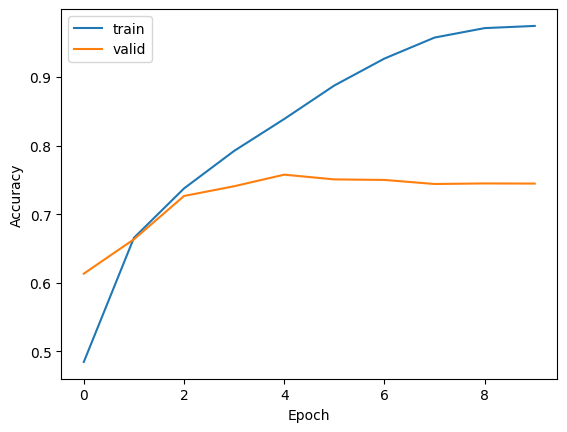

In [12]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.show()

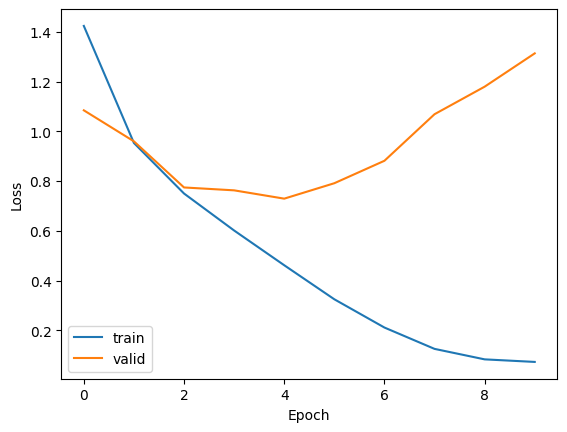

In [13]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.show()

In [14]:
#model.save("cifar10.h5")

In [15]:
labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [59]:
y_pred = model.predict(x_test[:5])

1/1 [==============================] - 0s 18ms/step


In [60]:
acc = np.sum(np.argmax(y_pred[:5], axis=1) == np.argmax(y_test[:5], axis=1)) / len(y_test[:5])

In [61]:
print(f"Accuracy before attack: {acc * 100: .2f}%")

Accuracy before attack:  60.00%


# Attack

In [20]:
model.channels_first = False

In [21]:
lb_attack = LaserBeamAttack(
    estimator = model,
    iterations = 50,
    max_laser_beam=(780, 3.14, 32, 32)
)

In [24]:
adv_images = []

for i in range(5):
    adv_image = lb_attack.generate(
        x=np.expand_dims(x_test[i], axis=0)
    )
    adv_images.append(adv_image)

1/1 [==============================] - 0s 16ms/step


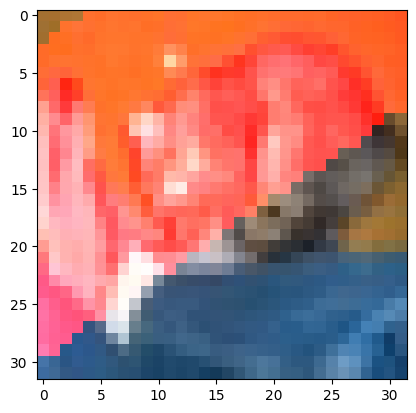

In [40]:
plt.imshow(adv_images[0][0])

In [68]:
adv_pred = []

for i in range(5):
    pred = model.predict(np.expand_dims(adv_images[i][0], 0))
    adv_pred.append(pred)

1/1 [==============================] - 0s 17ms/step


In [81]:
adv_acc = np.sum(np.argmax(adv_pred[:5][0], axis=1) == np.argmax(y_test[:5], axis=1)) / len(y_test[:5])

In [82]:
print(f"Accuracy after attack: {adv_acc * 100: .2f}%")

Accuracy after attack:  20.00%


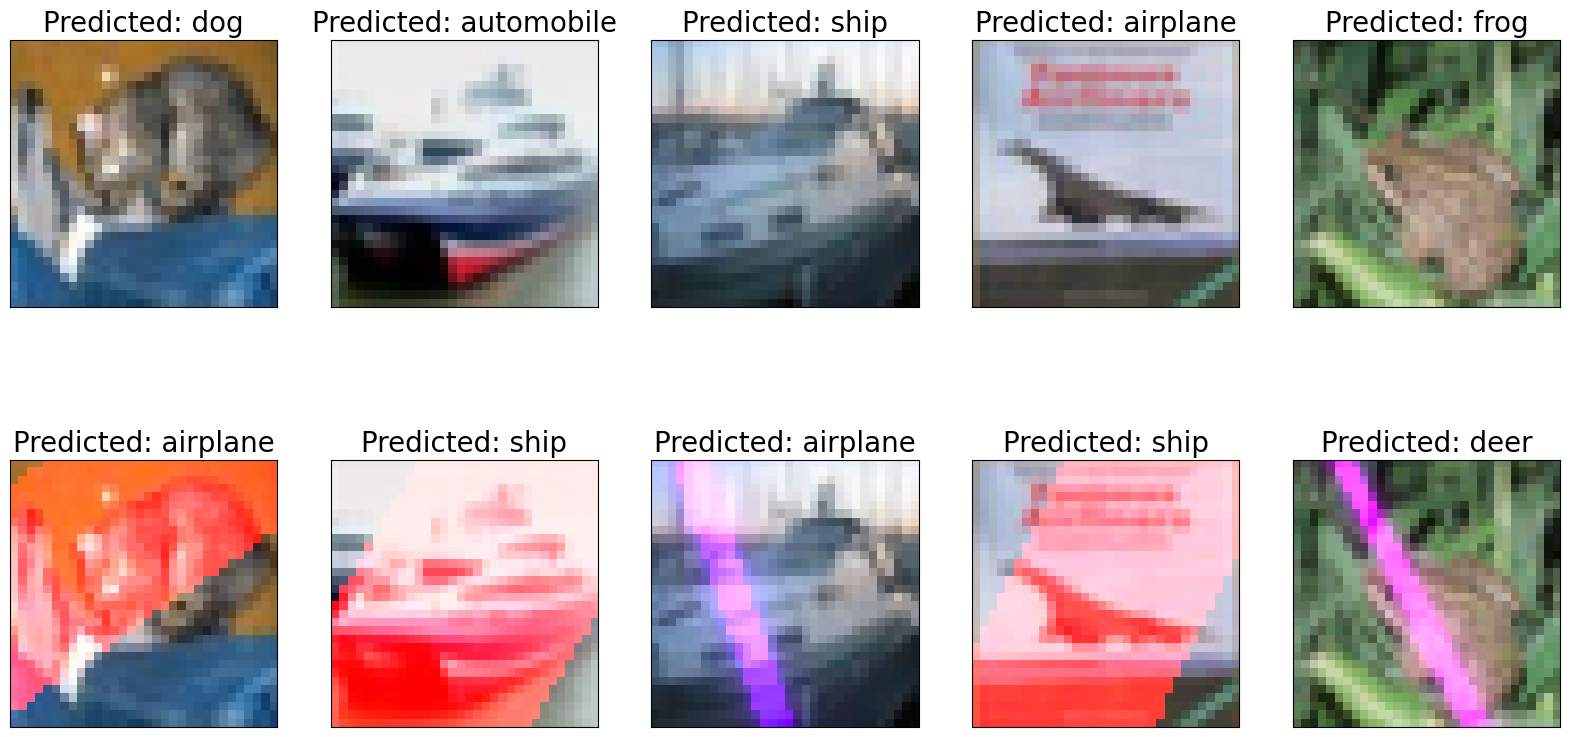

In [89]:
plt.figure(figsize=(20, 10))

for i in range(5):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i, :, :, :], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Predicted: {labels.get(y_pred[i].argmax())}", fontsize=20)
    
    ax = plt.subplot(2, 5, i+1+5)
    plt.imshow(adv_images[i][0], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Predicted: {labels.get(adv_pred[i].argmax())}", fontsize=20)
    
plt.show()